Ignacio Vellido Expósito

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Tensorflow no cuenta con ResNet18, se usa en cambio ResNet50

In [81]:
results = [
  ["Xception", 0.966667, 0.9875, 0.975309, 0.981366],
  ["VGG16", 0.9, 0.9, 1.0, 0.947368],
  ["VGG16 + Oversampling", 0.96875, 0.939759, 1.0, 0.968944],
  ["ResNet50", 1.0, 1.0, 1.0, 1.0],
  ["HOG + SVM", 0.966667, 0.963415, 1.0, 0.981366],
]

print("Sobre test")
pd.DataFrame(results, columns=["Arquitecture", "Accuracy", "Precision", "Recall", "F1 score"])

Sobre test


,Arquitecture,Accuracy,Precision,Recall,F1 score
0,Xception,0.966667,0.987500,0.975309,0.981366
1,VGG16,0.900000,0.900000,1.000000,0.947368
2,VGG16 + Oversampling,0.968750,0.939759,1.000000,0.968944
3,ResNet50,1.000000,1.000000,1.000000,1.000000
4,HOG + SVM,0.966667,0.963415,1.000000,0.981366


### **Análisis**

(Las CNN podrían mejorarse aún más modificando las últimas capas con cuidado)

<br>

En general obtenemos resultados muy buenos con cualquiera de los métodos, siendo perfectos con ResNet y seguidos de SVM y Xception. Este último en cambio tiene un recall ligeramente inferior, lo que en la semántica de este problema no es preferible, pues preferimos afirmar erróneamente que existe un peatón a decir que no.

El conjunto de datos está fuertemente desbalanceado, y VGG16 es el más afectado por ello. Podemos ver que igualando el número de imágenes por clase aumentamos 2 décimas su valor de F1.

<br>

Respecto a HOG, este es más rápido y menos costoso en memoria. Además, no es necesaria una cantidad de datos muy alta para aprender (aunque transfer learning en CNNs disminuye la importancia de este problema).

Por contra, aunque HOG+SVM se entrena más rápidamente su predicción es más lenta, pues necesita un preprocesamiento más costoso (calcular HOG) que para las redes (normalizar, incluir padding y/o hacer un resize).

<br>

(abajo hay gráficas y más detalles de los entrenamientos)

Train
   Accuracy  Precision  Recall   F1
0       1.0        1.0     1.0  1.0


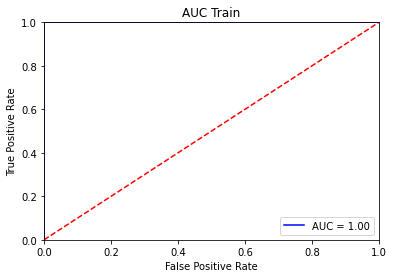

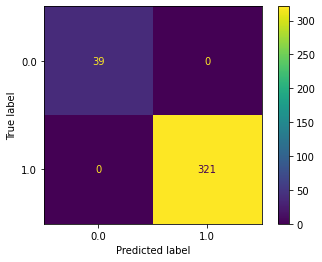

----------------------------------

Test
   Accuracy  Precision  Recall        F1
0  0.966667   0.963415     1.0  0.981366


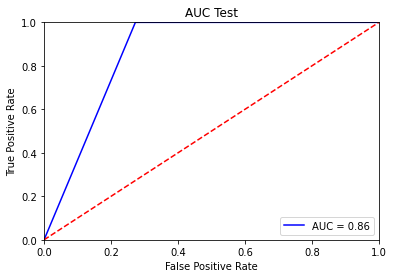

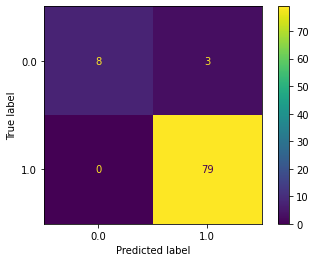

In [ ]:
# Resultados de SVM

evaluate_model(model, trn_x, trn_y, tst_x, tst_y)

In [2]:
################################################################################
# Libraries
################################################################################

# Import layers
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip # Flips verticales no tienen sentido
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomZoom

################################################################################

import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set numpy seed
np.random.seed(12345)

In [82]:
################################################################################
# Load data
################################################################################

# Adaptación de:
# https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
def load_images_from_folder(folder, resize_shape = None, subset_shape = None):
  """ Load images resizing and getting a random subset of shape @subset_shape
  if indicated """
  images = []

  for filename in sorted(os.listdir(folder)):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
      if resize_shape is not None:
        img = cv2.resize(img, resize_shape)

      shape = img.shape
      if subset_shape is not None:
        i = np.random.randint(0,shape[0] - subset_shape[0])
        j = np.random.randint(0,shape[1] - subset_shape[1])
        img = img[i : i+subset_shape[0], j : j+subset_shape[1]]

      images.append(img)

  return np.array(images)


path = "/content/drive/MyDrive/VC-T3/data/"
shape = (128,64)

pedestrians    = load_images_from_folder(path + "pedestrians128x64")
no_pedestrians = load_images_from_folder(path + "pedestrians_neg", (512,512), shape)

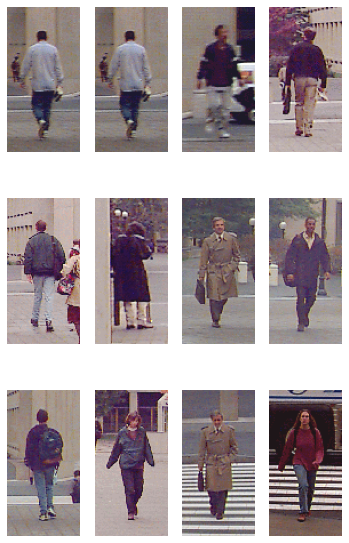

In [5]:
################################################################################
# Visualize data
################################################################################
plt.figure(figsize=(6, 10))

for i, img in enumerate(pedestrians[0:12]):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.axis("off")

plt.show()

In [70]:
################################################################################
# Preprocess data
################################################################################

# Get subset of 400 images
pedestrians = pedestrians[np.random.randint(pedestrians.shape[0], size=400)]

x = np.concatenate([pedestrians, no_pedestrians])

# Get labels
y = np.concatenate([np.ones(pedestrians.shape[0]), np.zeros(no_pedestrians.shape[0])])

---
---
---

In [41]:
# Preprocessing for Xception

# Minimum size is 71x71, so we add 0 padding right and left
def add_padding(img, left, right):
  return cv2.copyMakeBorder(img, 0, 0, left, right, cv2.BORDER_CONSTANT, 0)

x_padded = np.array(list(map(lambda img: add_padding(img, 4, 4), x)))
x_preprocessed = tf.keras.applications.xception.preprocess_input(x_padded)

# Train test split
tst_size = 0.2

trn_x, tst_x, trn_y, tst_y = train_test_split(x_preprocessed, y, 
                                              test_size=tst_size)

In [42]:
################################################################################
# Define model - Xception
################################################################################

input_shape = (128,72,3)

# Input layer
input = Input(shape=input_shape)

# Data augmentation
m = RandomFlip("horizontal")(input) # Only horizontals for this problem
m = RandomRotation(0.4)(m)

base_model = tf.keras.applications.Xception(
    weights="imagenet",      # Cargamos los pesos entrenados con ImageNet.
    input_shape=input_shape,
    include_top=False,       # Las primer capa  no se incluye
)

# Congelamos 
base_model.trainable = False

m = base_model(m, training=False)
m = GlobalAveragePooling2D()(m)
m = Dropout(0.2)(m)

output = Dense(1)(m)

model = Model(input, output)
model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 72, 3)]      0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 128, 72, 3)        0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 128, 72, 3)        0         
_________________________________________________________________
xception (Functional)        (None, 4, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
____________________________________________________________

In [43]:
################################################################################
# Fit model
################################################################################

# Parameters
epochs = 50
batch_size = 40
lr = "auto"

# Compile model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

Epoch 1/50
8/8 [==============================] - 5s 248ms/step - loss: 2.3715 - binary_accuracy: 0.7396 - val_loss: 1.0909 - val_binary_accuracy: 0.8611
Epoch 2/50
8/8 [==============================] - 0s 43ms/step - loss: 1.8074 - binary_accuracy: 0.8819 - val_loss: 1.2991 - val_binary_accuracy: 0.9167
Epoch 3/50
8/8 [==============================] - 0s 42ms/step - loss: 1.8023 - binary_accuracy: 0.8819 - val_loss: 1.2865 - val_binary_accuracy: 0.9028
Epoch 4/50
8/8 [==============================] - 0s 43ms/step - loss: 1.8016 - binary_accuracy: 0.8819 - val_loss: 1.2840 - val_binary_accuracy: 0.9028
Epoch 5/50
8/8 [==============================] - 0s 42ms/step - loss: 1.7501 - binary_accuracy: 0.8819 - val_loss: 1.2831 - val_binary_accuracy: 0.9028
Epoch 6/50
8/8 [==============================] - 0s 42ms/step - loss: 1.8003 - binary_accuracy: 0.8819 - val_loss: 1.2828 - val_binary_accuracy: 0.9028
Epoch 7/50
8/8 [==============================] - 0s 43ms/step - loss: 1.8003 - b

In [26]:
################################################################################
# Test model
################################################################################

def plot_history(history):
  acc = history.history["binary_accuracy"]
  val_acc = history.history["val_binary_accuracy"]

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  epochs = range(1, len(acc)+1)

  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, "r", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.figure()

  plt.show()

# ------------------------------------------------------------------------------

def get_scores(model, x, y, subset):
  loss, acc = model.evaluate(x, y, verbose=0)

  pred = model.predict(x)
  pred = (pred>.5)

  pre = precision_score(y, pred)
  rec = recall_score(y, pred)
  f1 = f1_score(y, pred)
  metrics = pd.DataFrame(columns=["Loss", "Accuracy", "Precision", "Recall", "F1"])
  metrics.loc[0] = [loss, acc, pre, rec, f1]
  
  print(metrics)

  plot_auc(y, pred, subset)

  cm = confusion_matrix(y, pred)

  print("{} confusion matrix".format(subset))
  print(pd.DataFrame(cm))

# ------------------------------------------------------------------------------

def evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y):
  print(model.summary())

  print("Max Epochs: {}".format(epochs))
  print("Last epoch: {}".format(len(history.epoch)))
  print("Batch size: {}".format(batch_size))
  print("Learning r: {}".format(lr))

  get_scores(model, trn_x, trn_y, "Train")
  print("----------------------------------\n")
  get_scores(model, tst_x, tst_y, "Test")
  print("\n")

  plot_history(history)

# ------------------------------------------------------------------------------

def plot_auc(y, preds,subset):
  fpr, tpr, threshold = roc_curve(y, preds)
  roc_auc = auc(fpr, tpr)

  plt.title("AUC {}".format(subset))
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 72, 3)]      0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 128, 72, 3)        0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 128, 72, 3)        0         
_________________________________________________________________
xception (Functional)        (None, 4, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049

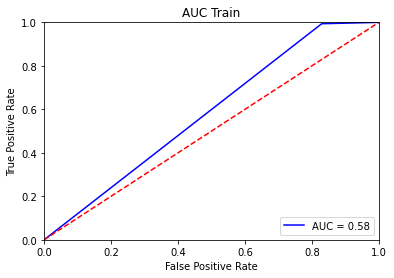

Train confusion matrix
   0    1
0  7   34
1  2  317
----------------------------------

       Loss  Accuracy  Precision  Recall        F1
0  1.081889       0.9        0.9     1.0  0.947368


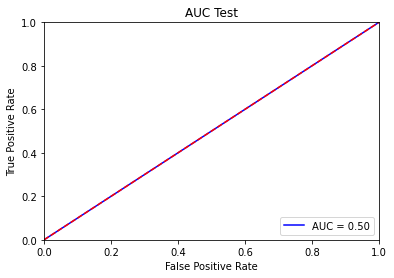

Test confusion matrix
   0   1
0  0   9
1  0  81




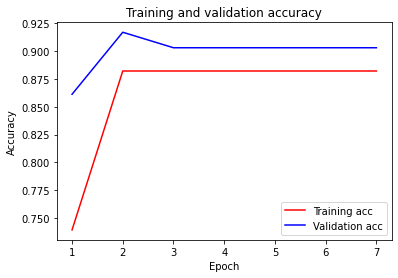

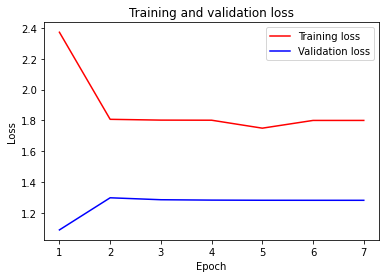

<Figure size 432x288 with 0 Axes>

In [44]:
evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

In [45]:
################################################################################
# Fine tuning
################################################################################

# Descongelamos el modelo base
base_model.trainable = True

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 72, 3)]      0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 128, 72, 3)        0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 128, 72, 3)        0         
_________________________________________________________________
xception (Functional)        (None, 4, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049

In [46]:
# Parameters
epochs = 25
lr = 1e-5

# Compile model
opt = tf.keras.optimizers.Adam(
        learning_rate=lr, 
      )
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
8/8 [==============================] - 7s 308ms/step - loss: 1.8024 - binary_accuracy: 0.8819 - val_loss: 1.2866 - val_binary_accuracy: 0.9028
Epoch 2/25
8/8 [==============================] - 1s 147ms/step - loss: 1.8003 - binary_accuracy: 0.8819 - val_loss: 1.2989 - val_binary_accuracy: 0.9028
Epoch 3/25
8/8 [==============================] - 1s 146ms/step - loss: 1.7488 - binary_accuracy: 0.8854 - val_loss: 1.2864 - val_binary_accuracy: 0.9028
Epoch 4/25
8/8 [==============================] - 1s 147ms/step - loss: 1.8003 - binary_accuracy: 0.8819 - val_loss: 1.2816 - val_binary_accuracy: 0.9028
Epoch 5/25
8/8 [==============================] - 1s 143ms/step - loss: 1.8003 - binary_accuracy: 0.8819 - val_loss: 1.2799 - val_binary_accuracy: 0.9167
Epoch 6/25
8/8 [==============================] - 1s 147ms/step - loss: 1.7077 - binary_accuracy: 0.8819 - val_loss: 0.6917 - val_binary_accuracy: 0.9306
Epoch 7/25
8/8 [==============================] - 1s 145ms/step - loss: 1.59

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 72, 3)]      0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 128, 72, 3)        0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 128, 72, 3)        0         
_________________________________________________________________
xception (Functional)        (None, 4, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2049

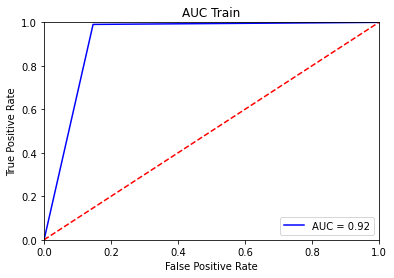

Train confusion matrix
    0    1
0  35    6
1   3  316
----------------------------------

       Loss  Accuracy  Precision    Recall        F1
0  0.286889  0.966667     0.9875  0.975309  0.981366


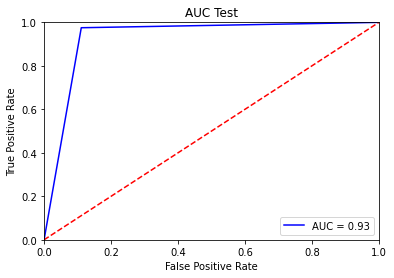

Test confusion matrix
   0   1
0  8   1
1  2  79




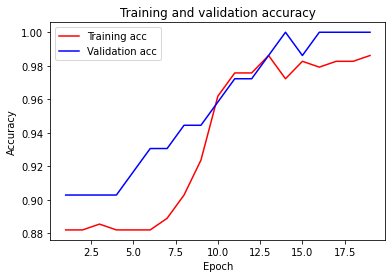

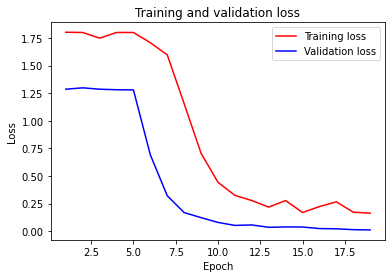

<Figure size 432x288 with 0 Axes>

In [47]:
################################################################################
# Evaluate
################################################################################

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

---

---

---

In [48]:
# Preprocessing for VGG16
# No need for padding

x_preprocessed = tf.keras.applications.vgg16.preprocess_input(x)

# Train test split
tst_size = 0.2

trn_x, tst_x, trn_y, tst_y = train_test_split(x_preprocessed, y, test_size=tst_size)

In [49]:
################################################################################
# Define model - VGG16
################################################################################

input_shape = (128,64,3)

# Input layer
input = Input(shape=input_shape)

# Data augmentation
m = RandomFlip("horizontal")(input)
m = RandomRotation(0.4)(m)

base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False,
)

# Congelamos 
base_model.trainable = False

m = base_model(m, training=False)
m = GlobalAveragePooling2D()(m)
m = Dropout(0.2)(m)

output = Dense(1)(m)

model = Model(input, output)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513 

In [50]:
################################################################################
# Fit model
################################################################################

# Parameters
epochs = 50

# Compile model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

Epoch 1/50
8/8 [==============================] - 1s 72ms/step - loss: 10.5249 - binary_accuracy: 0.2951 - val_loss: 9.5149 - val_binary_accuracy: 0.3194
Epoch 2/50
8/8 [==============================] - 0s 38ms/step - loss: 7.5273 - binary_accuracy: 0.4931 - val_loss: 5.2478 - val_binary_accuracy: 0.6111
Epoch 3/50
8/8 [==============================] - 0s 38ms/step - loss: 4.6378 - binary_accuracy: 0.6701 - val_loss: 2.7852 - val_binary_accuracy: 0.8194
Epoch 4/50
8/8 [==============================] - 0s 38ms/step - loss: 3.1020 - binary_accuracy: 0.7951 - val_loss: 2.1534 - val_binary_accuracy: 0.8472
Epoch 5/50
8/8 [==============================] - 0s 40ms/step - loss: 2.1853 - binary_accuracy: 0.8507 - val_loss: 1.7413 - val_binary_accuracy: 0.8750
Epoch 6/50
8/8 [==============================] - 0s 40ms/step - loss: 2.0208 - binary_accuracy: 0.8646 - val_loss: 1.5133 - val_binary_accuracy: 0.8889
Epoch 7/50
8/8 [==============================] - 0s 40ms/step - loss: 1.9712 - b

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513 

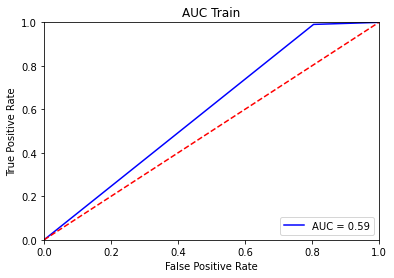

Train confusion matrix
   0    1
0  8   33
1  3  316
----------------------------------

       Loss  Accuracy  Precision  Recall        F1
0  1.524924       0.9        0.9     1.0  0.947368


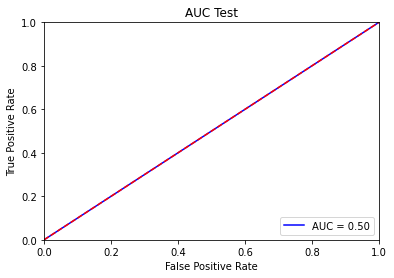

Test confusion matrix
   0   1
0  0   9
1  0  81




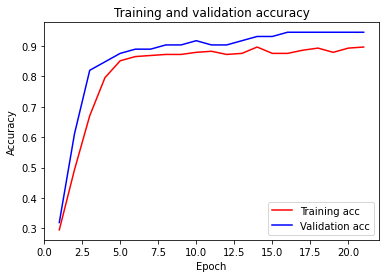

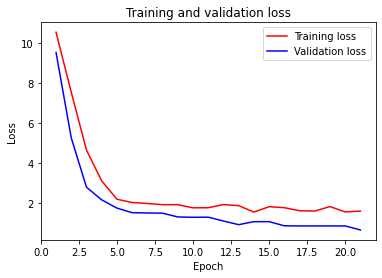

<Figure size 432x288 with 0 Axes>

In [51]:
################################################################################
# Evaluate
################################################################################

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

In [52]:
################################################################################
# Fine tuning
################################################################################

# Descongelamos el modelo base
base_model.trainable = True

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513 

In [53]:
# Parameters
epochs = 25
lr = 1e-5

# Compile model
opt = tf.keras.optimizers.Adam(
        learning_rate=lr, 
      )
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

Epoch 1/25
8/8 [==============================] - 2s 120ms/step - loss: 1.6950 - binary_accuracy: 0.8889 - val_loss: 0.8574 - val_binary_accuracy: 0.9444
Epoch 2/25
8/8 [==============================] - 1s 95ms/step - loss: 1.5393 - binary_accuracy: 0.8958 - val_loss: 0.8496 - val_binary_accuracy: 0.9444
Epoch 3/25
8/8 [==============================] - 1s 94ms/step - loss: 1.5367 - binary_accuracy: 0.8993 - val_loss: 0.8496 - val_binary_accuracy: 0.9444
Epoch 4/25
8/8 [==============================] - 1s 94ms/step - loss: 1.4394 - binary_accuracy: 0.9028 - val_loss: 0.6354 - val_binary_accuracy: 0.9583
Epoch 5/25
8/8 [==============================] - 1s 94ms/step - loss: 1.4832 - binary_accuracy: 0.9028 - val_loss: 0.6354 - val_binary_accuracy: 0.9583
Epoch 6/25
8/8 [==============================] - 1s 94ms/step - loss: 1.3780 - binary_accuracy: 0.9097 - val_loss: 0.6354 - val_binary_accuracy: 0.9583
Epoch 7/25
8/8 [==============================] - 1s 94ms/step - loss: 1.3801 - b

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513 

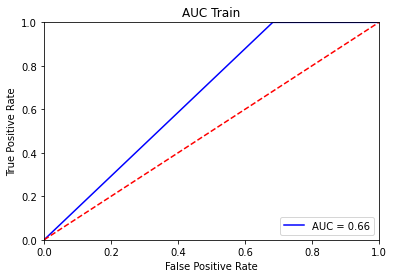

Train confusion matrix
    0    1
0  13   28
1   0  319
----------------------------------

       Loss  Accuracy  Precision  Recall        F1
0  1.524924       0.9        0.9     1.0  0.947368


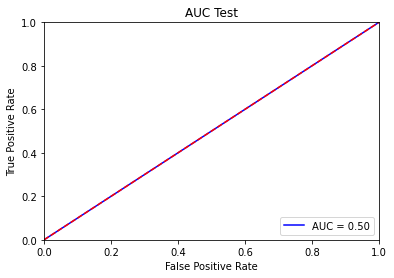

Test confusion matrix
   0   1
0  0   9
1  0  81




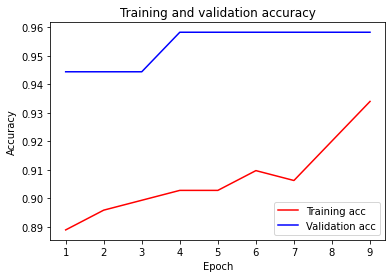

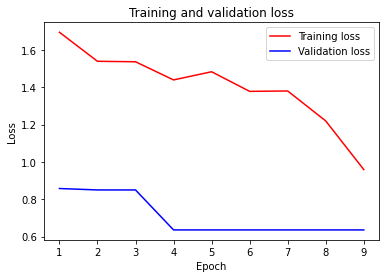

<Figure size 432x288 with 0 Axes>

In [54]:
################################################################################
# Evaluate
################################################################################

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

---

---

---

In [ ]:
################################################################################
# No-pedestrians oversampling
################################################################################

for i in range(7):
  a = load_images_from_folder(path + "pedestrians_neg", (512,512), shape)
  no_pedestrians = np.concatenate((no_pedestrians, a))

np.unique(no_pedestrians, axis=0).shape

In [71]:
# Preprocessing for VGG16
# No need for padding

x_preprocessed = tf.keras.applications.vgg16.preprocess_input(x)

# Train test split
tst_size = 0.2

trn_x, tst_x, trn_y, tst_y = train_test_split(x_preprocessed, y, test_size=tst_size)

In [72]:
################################################################################
# Define model - VGG16
################################################################################

input_shape = (128,64,3)

# Input layer
input = Input(shape=input_shape)

# Data augmentation
m = RandomFlip("horizontal")(input)
m = RandomRotation(0.4)(m)

base_model = tf.keras.applications.VGG16(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False,
)

# Congelamos 
base_model.trainable = False

m = base_model(m, training=False)
m = GlobalAveragePooling2D()(m)
m = Dropout(0.2)(m)

output = Dense(1)(m)

model = Model(input, output)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513 

In [73]:
################################################################################
# Fit model
################################################################################

# Parameters
epochs = 50

# Compile model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

Epoch 1/50
13/13 [==============================] - 2s 64ms/step - loss: 5.6097 - binary_accuracy: 0.6152 - val_loss: 4.6019 - val_binary_accuracy: 0.6641
Epoch 2/50
13/13 [==============================] - 1s 40ms/step - loss: 3.9498 - binary_accuracy: 0.7188 - val_loss: 3.9900 - val_binary_accuracy: 0.7344
Epoch 3/50
13/13 [==============================] - 1s 40ms/step - loss: 2.8134 - binary_accuracy: 0.8027 - val_loss: 3.7297 - val_binary_accuracy: 0.7422
Epoch 4/50
13/13 [==============================] - 1s 40ms/step - loss: 2.9306 - binary_accuracy: 0.7949 - val_loss: 3.4902 - val_binary_accuracy: 0.7578
Epoch 5/50
13/13 [==============================] - 1s 40ms/step - loss: 2.2410 - binary_accuracy: 0.8418 - val_loss: 3.4812 - val_binary_accuracy: 0.7656
Epoch 6/50
13/13 [==============================] - 1s 40ms/step - loss: 2.3145 - binary_accuracy: 0.8320 - val_loss: 3.3685 - val_binary_accuracy: 0.7656
Epoch 7/50
13/13 [==============================] - 1s 40ms/step - los

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513 

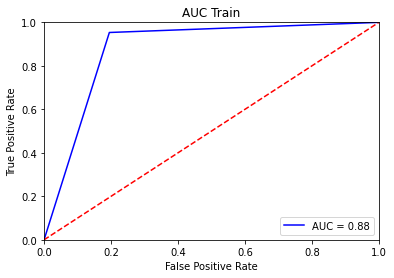

Train confusion matrix
     0    1
0  256   62
1   15  307
----------------------------------

       Loss  Accuracy  Precision    Recall        F1
0  2.776521    0.8125    0.76087  0.897436  0.823529


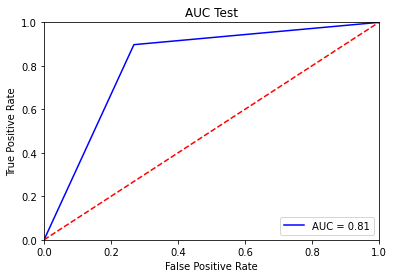

Test confusion matrix
    0   1
0  60  22
1   8  70




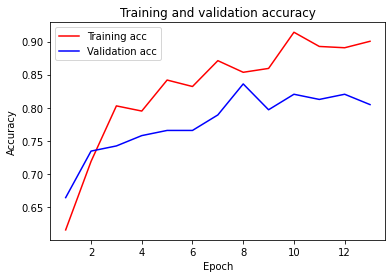

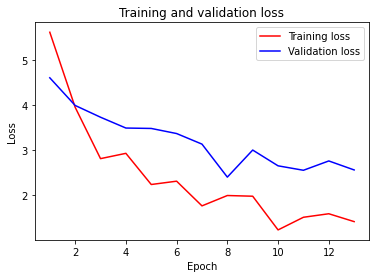

<Figure size 432x288 with 0 Axes>

In [74]:
################################################################################
# Evaluate
################################################################################

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

In [75]:
################################################################################
# Fine tuning
################################################################################

# Descongelamos el modelo base
base_model.trainable = True

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513 

In [78]:
# Parameters
epochs = 25
lr = 1e-5

# Compile model
opt = tf.keras.optimizers.Adam(
        learning_rate=lr, 
      )
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

Epoch 1/25
13/13 [==============================] - 4s 258ms/step - loss: 1.8466 - binary_accuracy: 0.8652 - val_loss: 1.7105 - val_binary_accuracy: 0.8672
Epoch 2/25
13/13 [==============================] - 1s 101ms/step - loss: 0.9971 - binary_accuracy: 0.9316 - val_loss: 2.2783 - val_binary_accuracy: 0.8516
Epoch 3/25
13/13 [==============================] - 1s 101ms/step - loss: 1.5147 - binary_accuracy: 0.8965 - val_loss: 2.1569 - val_binary_accuracy: 0.8516
Epoch 4/25
13/13 [==============================] - 1s 100ms/step - loss: 1.1633 - binary_accuracy: 0.9238 - val_loss: 2.3827 - val_binary_accuracy: 0.8438
Epoch 5/25
13/13 [==============================] - 1s 100ms/step - loss: 1.2273 - binary_accuracy: 0.9160 - val_loss: 1.7875 - val_binary_accuracy: 0.8828
Epoch 6/25
13/13 [==============================] - 1s 100ms/step - loss: 0.7293 - binary_accuracy: 0.9512 - val_loss: 0.3688 - val_binary_accuracy: 0.9688
Epoch 7/25
13/13 [==============================] - 1s 101ms/ste

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 128, 64, 3)        0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513 

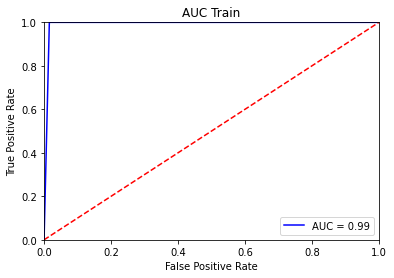

Train confusion matrix
     0    1
0  313    5
1    0  322
----------------------------------

       Loss  Accuracy  Precision  Recall        F1
0  0.400057   0.96875   0.939759     1.0  0.968944


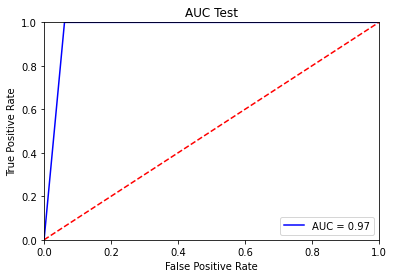

Test confusion matrix
    0   1
0  77   5
1   0  78




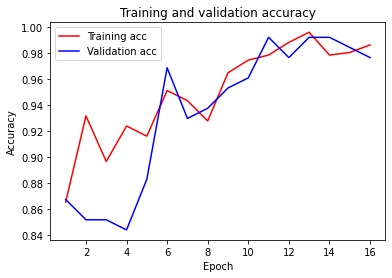

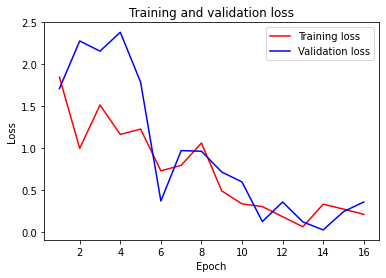

<Figure size 432x288 with 0 Axes>

In [79]:
################################################################################
# Evaluate
################################################################################

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

---

---

---

In [22]:
# Preprocessing for ResNet50
x_preprocessed = tf.keras.applications.resnet50.preprocess_input(x)

# Train test split
tst_size = 0.2

trn_x, tst_x, trn_y, tst_y = train_test_split(x_preprocessed, y, test_size=tst_size)

In [23]:
################################################################################
# Define model - ResNet50
################################################################################

input_shape = (128,64,3)

# Input layer
input = Input(shape=input_shape)

# Data augmentation
m = RandomFlip("horizontal")(input)
m = RandomRotation(0.4)(m)

base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False
)

# Congelamos 
base_model.trainable = False

m = base_model(m, training=False)
m = GlobalAveragePooling2D()(m)
m = Dropout(0.2)(m)

output = Dense(1)(m)

model = Model(input, output)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation (RandomRotat (None, 128, 64, 3)        0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
______________________________________________________________

In [24]:
################################################################################
# Fit model
################################################################################

# Parameters
epochs = 50
batch_size = 40
lr = "auto"

# Compile model
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

Epoch 1/50
8/8 [==============================] - 35s 257ms/step - loss: 7.4243 - binary_accuracy: 0.4410 - val_loss: 3.2907 - val_binary_accuracy: 0.7361
Epoch 2/50
8/8 [==============================] - 0s 38ms/step - loss: 2.0537 - binary_accuracy: 0.8507 - val_loss: 1.5078 - val_binary_accuracy: 0.8889
Epoch 3/50
8/8 [==============================] - 0s 39ms/step - loss: 1.7126 - binary_accuracy: 0.8785 - val_loss: 1.4853 - val_binary_accuracy: 0.9028
Epoch 4/50
8/8 [==============================] - 0s 39ms/step - loss: 1.8273 - binary_accuracy: 0.8681 - val_loss: 1.4857 - val_binary_accuracy: 0.9028
Epoch 5/50
8/8 [==============================] - 0s 38ms/step - loss: 1.7138 - binary_accuracy: 0.8785 - val_loss: 1.4845 - val_binary_accuracy: 0.9028
Epoch 6/50
8/8 [==============================] - 0s 38ms/step - loss: 1.5671 - binary_accuracy: 0.8854 - val_loss: 1.3017 - val_binary_accuracy: 0.9028
Epoch 7/50
8/8 [==============================] - 0s 39ms/step - loss: 1.4903 - 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation (RandomRotat (None, 128, 64, 3)        0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

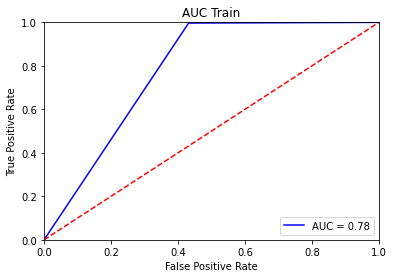

Train confusion matrix
    0    1
0  25   19
1   1  315
----------------------------------

       Loss  Accuracy  Precision  Recall        F1
0  0.677744  0.955556   0.954545     1.0  0.976744


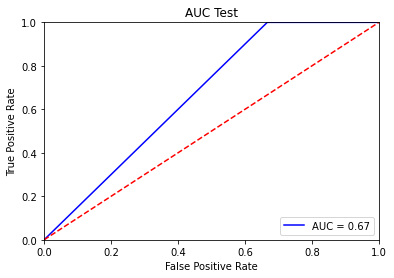

Test confusion matrix
   0   1
0  2   4
1  0  84




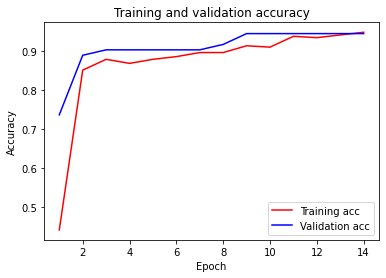

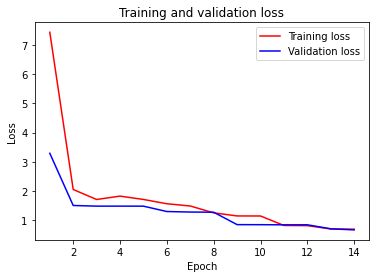

<Figure size 432x288 with 0 Axes>

In [29]:
################################################################################
# Evaluate
################################################################################

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)

In [30]:
################################################################################
# Fine tuning
################################################################################

# Descongelamos el modelo base
base_model.trainable = True

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation (RandomRotat (None, 128, 64, 3)        0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [31]:
# Parameters
epochs = 25
lr = 1e-5

# Compile model
opt = tf.keras.optimizers.Adam(
        learning_rate=lr, 
      )
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

# EarlyStopping callback
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', 
                                                  patience=5,
                                                  restore_best_weights=True)

# Fitting
history = model.fit(x=trn_x, y=trn_y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    callbacks=[early_callback],
          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
8/8 [==============================] - 9s 277ms/step - loss: 1.0276 - binary_accuracy: 0.9236 - val_loss: 0.6547 - val_binary_accuracy: 0.9444
Epoch 2/25
8/8 [==============================] - 1s 97ms/step - loss: 0.6957 - binary_accuracy: 0.9514 - val_loss: 0.6444 - val_binary_accuracy: 0.9583
Epoch 3/25
8/8 [==============================] - 1s 96ms/step - loss: 0.4435 - binary_accuracy: 0.9583 - val_loss: 0.6354 - val_binary_accuracy: 0.9583
Epoch 4/25
8/8 [==============================] - 1s 96ms/step - loss: 0.3368 - binary_accuracy: 0.9653 - val_loss: 0.4252 - val_binary_accuracy: 0.9722
Epoch 5/25
8/8 [==============================] - 1s 96ms/step - loss: 0.3758 - binary_accuracy: 0.9722 - val_loss: 0.2237 - val_binary_accuracy: 0.9722
Epoch 6/25
8/8 [==============================] - 1s 96ms/step - loss: 0.1695 - binary_accuracy: 0.9826 - val_loss: 0.2118 - val_binary_accuracy: 0.9861
Epoch 7/25
8/8 [==============================] - 1s 96ms/step - loss: 0.3256 - b

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 64, 3)]      0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 128, 64, 3)        0         
_________________________________________________________________
random_rotation (RandomRotat (None, 128, 64, 3)        0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

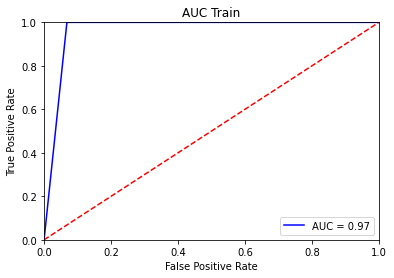

Train confusion matrix
    0    1
0  41    3
1   0  316
----------------------------------

   Loss  Accuracy  Precision  Recall   F1
0   0.0       1.0        1.0     1.0  1.0


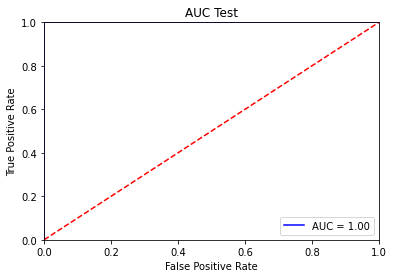

Test confusion matrix
   0   1
0  6   0
1  0  84




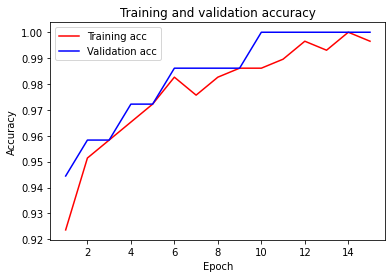

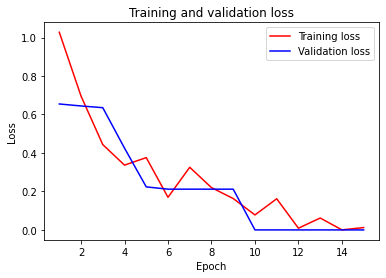

<Figure size 432x288 with 0 Axes>

In [32]:
################################################################################
# Evaluate
################################################################################

evaluate_model(model, history, trn_x, trn_y, tst_x, tst_y)